# MODIS Level 3 - Burned Area Monthly - 500m

```{hint} 
<a href='https://fire.ltpy.adamplatform.eu/hub/user-redirect/lab/tree/med_part3_workflows/figure1_MODIS_BurnedArea_Monthly.ipynb' target='_blank'>Execute the notebook on the training platform >></a>
```

This notebook provides you an introduction to data from the [Moderate Resolution Imaging Spectroradiometer (MODIS)](https://modis.gsfc.nasa.gov/about/). It uses MODIS as a proxy dataset for [METImage](https://www.eumetsat.int/eps-sg-metimage) on EPS-SG, which is a multi-spectral (visible and IR) imaging passive radiometer which will provide detailed information on clouds, wind, aerosols and surface properties which are essential for meteorological and climate applications. 

The events featured in this notebook are the wildfires in Italy and Greece in summer 2021. 

```{admonition} Basic Facts
**Spatial resolution**: `500 m at nadir`<br>
**Spatial coverage**: `Global` <br>
**Time step**: `Monthly` <br>
**Data availability**: `since 2000`
```

```{admonition} How to access the data
This notebook uses the MODIS MCD64A1 dataset from the Terra and Aqua platforms.  This data can be ordered via the [LAADS DAAC](https://ladsweb.modaps.eosdis.nasa.gov/search/order/2/MCD64A1--6) and are distributed in `HDF4-EOS` format, which is based on `HDF4`. 

You need to [register for an Earthdata account](https://urs.earthdata.nasa.gov/) before being able to download data.
```

<hr>

**Load required libraries**

In [1]:
import os
import xarray as xr
import numpy as np
from osgeo import gdal,osr
import pyproj
import pandas as pd
import glob

# Python libraries for visualization
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.axes import Axes
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

**Load helper functions**

In [2]:
%run ../functions.ipynb

<hr>

## Load and browse MODIS Aerosol Product data

You will use the Python library `gdal` to open a HDF4 data file from 8th September 2015. Read more about `gdal` [here](https://gdal.org/). 

### Inspect the structure of one MODIS MOD04 data file

The data is from August 2020 and is stored in the folder `../data/modis/level3/burnedarea/2020/08/`. You can use the function `gdal.Open(file_path)` to load one single file to better understand the data structure. The results in a `gdal.Dataset`.

In [3]:
file_path = '../data/modis/level3/burnedarea/2021/08/MCD64A1.A2021213.h19v05.061.2021309115552.hdf'

hdf_handle = gdal.Open(file_path)
hdf_handle

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f358467b990> >

Next, you can print a list of all of the datasets within the hdf file using the function `.GetSubDatasets()` from the gdal library. There are several sub-datasets printed:

- `Burn Date`: the burn date in ordinal days
- `Burn Date Uncertainty`: the uncertainty value for the burn date
- `QA`: the quality assurance dataset
- `First Day`: the first day of burn
- `Last Day`: the last day of burn

In [4]:
sds_list = hdf_handle.GetSubDatasets()

for sds in sds_list:
    print(sds)

('HDF4_EOS:EOS_GRID:"../data/modis/level3/burnedarea/2021/08/MCD64A1.A2021213.h19v05.061.2021309115552.hdf":MOD_Grid_Monthly_500m_DB_BA:"Burn Date"', '[2400x2400] Burn Date MOD_Grid_Monthly_500m_DB_BA (16-bit integer)')
('HDF4_EOS:EOS_GRID:"../data/modis/level3/burnedarea/2021/08/MCD64A1.A2021213.h19v05.061.2021309115552.hdf":MOD_Grid_Monthly_500m_DB_BA:"Burn Date Uncertainty"', '[2400x2400] Burn Date Uncertainty MOD_Grid_Monthly_500m_DB_BA (8-bit unsigned integer)')
('HDF4_EOS:EOS_GRID:"../data/modis/level3/burnedarea/2021/08/MCD64A1.A2021213.h19v05.061.2021309115552.hdf":MOD_Grid_Monthly_500m_DB_BA:QA', '[2400x2400] QA MOD_Grid_Monthly_500m_DB_BA (8-bit unsigned integer)')
('HDF4_EOS:EOS_GRID:"../data/modis/level3/burnedarea/2021/08/MCD64A1.A2021213.h19v05.061.2021309115552.hdf":MOD_Grid_Monthly_500m_DB_BA:"First Day"', '[2400x2400] First Day MOD_Grid_Monthly_500m_DB_BA (16-bit integer)')
('HDF4_EOS:EOS_GRID:"../data/modis/level3/burnedarea/2021/08/MCD64A1.A2021213.h19v05.061.2021309

Next, you open the sub-datasets for the burn date and QA using the function `gdal.Open()`. 

The subdatasets are organized as an array. You can use `sds_list[D][0]` to select the dataset of interest, the relevant values of D are:
- `0`: Burn Date
- `1`: Burn Date Uncertainty
- `2`: QA
- `3`: First Day
- `4`: Last Day

In [5]:
burndate_handle = gdal.Open(sds_list[0][0])
qa_handle = gdal.Open(sds_list[2][0])

Next, you can use the function `.ReadAsArray()` from the gdal library to read in the data. You also use the numpy library to set the type as float.

In [6]:
burndate_data = burndate_handle.ReadAsArray().astype(np.float64)
qa_data = qa_handle.ReadAsArray().astype(np.float64)

Now, you can use the numpy library to take a look at the shape and type of the data array. You can inspect the shape using `np.shape()` and get the data type using `.dtype`.

In [7]:
print(np.shape(burndate_data))
print(qa_data.dtype)

(2400, 2400)
float64


The `burndate_data` variable contains an array of the burn date values.

In [8]:
burndate_data

array([[-2., -2., -2., ..., -2., -2., -2.],
       [-2., -2., -2., ..., -2., -2., -2.],
       [-2., -2., -2., ..., -2., -2., -2.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

The maximum value of the burn dates can be viewed using the function `.max()` from the numpy library.

In [9]:
burndate_data.max()

240.0

### Retrieve attributes fom the metadata

Next, you need to retrieve attributes from the dataset for plotting purposes using the function `.GetMetadata()`. The first step is to store the global attributes dictionary from the dataset as a variable called `meta`. 

In [10]:
meta = burndate_handle.GetMetadata()

The attributes dictionary includes a few useful attributes including `long_name`, `_FillValue`, `_WaterValue`, and `valid_range`. You can define variables for these for use in visualizing the data later. It is also important to assign the float data type using `np.float` to the `_FillValue`, `_WaterValue` and`valid_range`.

In [11]:
_FillValue = np.float(meta['_FillValue'])
long_name = meta['long_name']
_WaterValue = np.float(meta['water'])
valid_range = [np.float(x) for x in meta['valid_range'].split(', ')]

### Replace fill, water and unburned value pixels with nan

Next, you can replace all data which has the value of `-1`, which is the fill value, with `nan` which stands for "Not a Number". 

In [12]:
burndate_data[burndate_data == _FillValue] = np.nan
burndate_data

array([[-2., -2., -2., ..., -2., -2., -2.],
       [-2., -2., -2., ..., -2., -2., -2.],
       [-2., -2., -2., ..., -2., -2., -2.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

Then, let's replace all data which has the value of `-2`, which is the water value, with `nan` which stands for "Not a Number". 

In [13]:
burndate_data[burndate_data == _WaterValue] = np.nan
burndate_data

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

Then, let's replace all data which has the value of `0`, which is the unburned value, with `nan` which stands for "Not a Number". 

In [14]:
burndate_data[burndate_data == 0] = np.nan
burndate_data

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

## Construct a grid and georeference the burned area data

### Construct the grid

Next, you can construct a grid to plot the burned area data. First, use the `.GetGeoTransform()` function from the gdal library to obtain six coefficients which map the pixel coordinates of the data. This is also referred to as the [affine transform](https://gdal.org/user/raster_data_model.html#affine-geotransform).

You can store the following coefficients as variables: 

- `xinc`: the pixel width
- `yinc`: the pixel height
- `x0` and `y0`: the x and y-coordinates of the top left corner of the top left pixel of the raster

In [15]:
x0, xinc, _, y0, _, yinc = burndate_handle.GetGeoTransform()

Next, store the size of the raster along the x and y-axes as two separate variables, `nx` and `ny`. 

In [16]:
nx, ny = (burndate_handle.RasterXSize, burndate_handle.RasterYSize)

The function `.linspace()` from the numpy library returns evenly spaced numbers over a specified interval. You can use the variables you have already defined to generate the coordinate vectors that will be used to define the grid. Finally, you can use the function `.meshgrid()` from the numpy library to create coordinate matrices from x and y coordinate vectors.

In [17]:
x = np.linspace(x0, x0 + xinc*nx, nx)
y = np.linspace(y0, y0 + yinc*ny, ny)
xv, yv = np.meshgrid(x, y)

### Georeference the data by transforming the grid

Next, you can define the two projection systems, namely the sinusoidal projection and WGS84, using the Python library called [pyproj](https://pyproj4.github.io/pyproj/stable/). You are then able to transform the grid you created earlier into longitude and latitude values. 

In [18]:
sinu = pyproj.Proj("+proj=sinu +R=6371007.181 +nadgrids=@null +wktext")
wgs84 = pyproj.Proj("+init=EPSG:4326") 
lon, lat= pyproj.transform(sinu, wgs84, xv, yv)

If you print the variables `lon` and `lat`, which contain the longitude and latitude values respectively, you will see the following arrays.

In [19]:
lon

array([[13.05407289, 13.05951436, 13.06495582, ..., 26.09726285,
        26.10270432, 26.10814578],
       [13.05327607, 13.0587172 , 13.06415833, ..., 26.09566987,
        26.10111101, 26.10655214],
       [13.05247941, 13.05792021, 13.06336101, ..., 26.09407723,
        26.09951803, 26.10495883],
       ...,
       [11.54797562, 11.55278928, 11.55760294, ..., 23.08632391,
        23.09113757, 23.09595124],
       [11.54749045, 11.55230391, 11.55711737, ..., 23.08535398,
        23.09016744, 23.0949809 ],
       [11.54700538, 11.55181864, 11.5566319 , ..., 23.08438425,
        23.08919751, 23.09401076]])

In [20]:
lat

array([[40.        , 40.        , 40.        , ..., 40.        ,
        40.        , 40.        ],
       [39.99583159, 39.99583159, 39.99583159, ..., 39.99583159,
        39.99583159, 39.99583159],
       [39.99166319, 39.99166319, 39.99166319, ..., 39.99166319,
        39.99166319, 39.99166319],
       ...,
       [30.0083368 , 30.0083368 , 30.0083368 , ..., 30.0083368 ,
        30.0083368 , 30.0083368 ],
       [30.0041684 , 30.0041684 , 30.0041684 , ..., 30.0041684 ,
        30.0041684 , 30.0041684 ],
       [30.        , 30.        , 30.        , ..., 30.        ,
        30.        , 30.        ]])

## Visualize MODIS burned area data with Cartopy features

For visualization, you can use the function [](functions:visualize_pcolormesh) to visualize the data. The following keyword arguments have to be defined:
* `data_array`
* `longitude`
* `latitude`
* `projection`
* `color palette`
* `unit`
* `long_name`
* `vmin`, 
* `vmax`
* `extent (lonmin, lonmax, latmin, latmax)`
* `set_global`

We set the `vmin` and `vmax` values to 214 and 244 respectively, which are the ordinal days for the first and last day of the month of August 2020. We set the extent of the plot to highlight burned areas in southern Italy and in Greece.

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'MODIS/Terra+Aqua Burned Area Monthly L3 Global 500 m SIN Grid \nordinal day of burn in August 2021'}>)

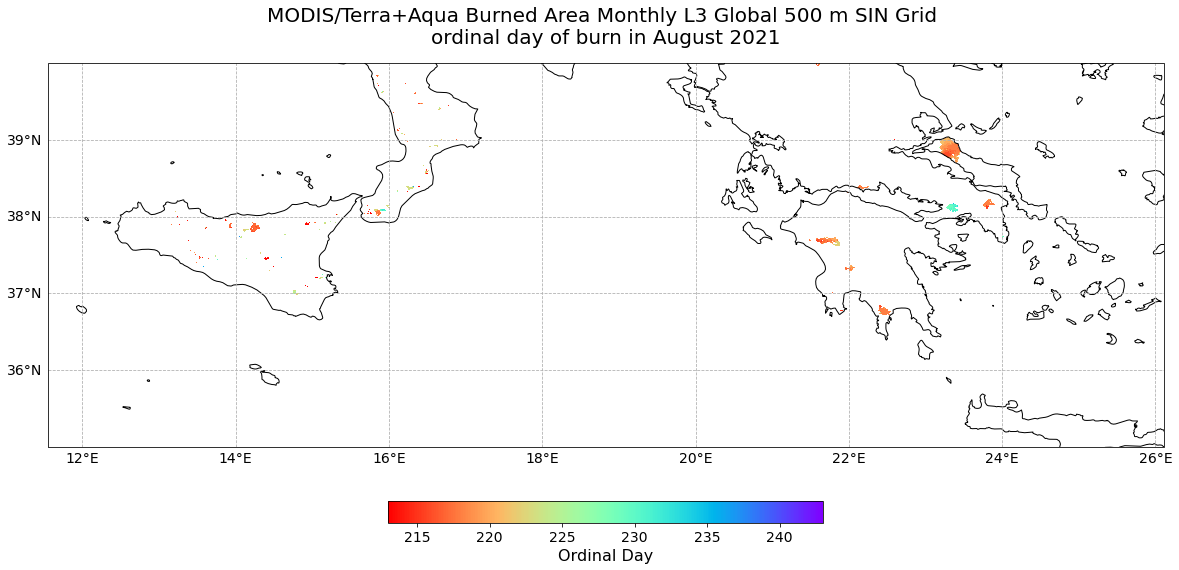

In [21]:
visualize_pcolormesh(data_array=burndate_data,
                     longitude=lon,
                     latitude=lat,
                     projection=ccrs.PlateCarree(),
                     color_scale='rainbow_r',
                     unit='Ordinal Day',
                     long_name='MODIS/Terra+Aqua Burned Area Monthly L3 Global 500 m SIN Grid \n' + long_name + ' in August 2021',
                     vmin=213, 
                     vmax=243,
                     lonmin=lon.min(),
                     lonmax=lon.max(),
                     latmin=35,
                     latmax=lat.max(),
                     set_global=False)

<hr>

### References
* Giglio, L., Justice, C., Boschetti, L., Roy, D. (2021). MODIS/Terra+Aqua Burned Area Monthly L3 Global 500m SIN Grid V061 [Data set]. NASA EOSDIS Land Processes DAAC. https://doi.org/10.5067/MODIS/MCD64A1.061

* Some code in this notebook was adapted from the following source:
    * origin: https://hdfeos.org/zoo/LPDAAC/MCD43A3_A2013305_h12v11_005_2013322102420.py
    * copyright: 2014, John Evans
    * license: Public Domain
    * retrieved: 2022-06-28 by Sabrina Szeto

```{admonition} Return to the case study
Assessing post-fire impacts with next-generation satellites: Mediterranean Fires Case Study <br>
[](med_part3_fig1)
```